## Local Outlier Factor Practice (Novelty detection)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score

%matplotlib inline

In [36]:
#Example settings

n_samples = 500
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

labels = np.append(np.zeros(n_inliers), np.ones(n_outliers)).astype(int)

In [37]:
## Generate datasets (85% inlier, 15% outlier)

blob_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0,0],[0,0]], cluster_std=0.5, 
              **blob_params)[0],
    make_blobs(centers=[[2,2],[-2,-2]], cluster_std=[0.5, 0.5], 
              **blob_params)[0],
    make_blobs(centers=[[2,2],[-2,-2]], cluster_std=[1.5, .3], 
              **blob_params)[0],
    4. * make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
    np.array([0.5,0.25]),
    14. * (np.random.RandomState(0).rand(n_inliers, 2) - 0.5)
]

def add_outlier(normal_dataset, n_outlier, delta_ratio=0.1, random_state=0):
    max_values = normal_dataset.max(axis=0)
    min_values = normal_dataset.min(axis=0)
    delta = delta_ratio * (max_values - min_values)
    np.random.seed=random_state
    arr_outlier = np.random.uniform(low=min_values - delta, 
                                    high=max_values + delta, 
                                    size=(n_outliers, len(max_values)),
                                   )
    return np.concatenate([normal_dataset, arr_outlier], axis=0)

for n, dataset in enumerate(datasets):
    datasets[n] = add_outlier(dataset, n_outlier=n_outliers)
    
colors = np.array(['#377eb8', '#ff7f00'])

np.unique(labels, return_counts=True)

(array([0, 1]), array([425,  75]))

In [38]:
## Train, Test split
train_ratio = 0.8
train_size = int(n_inliers * train_ratio)

X_trains = [dataset[:train_size,:] for dataset in datasets]
X_tests = [dataset[train_size:,:] for dataset in datasets]
y_test = labels[train_size:]

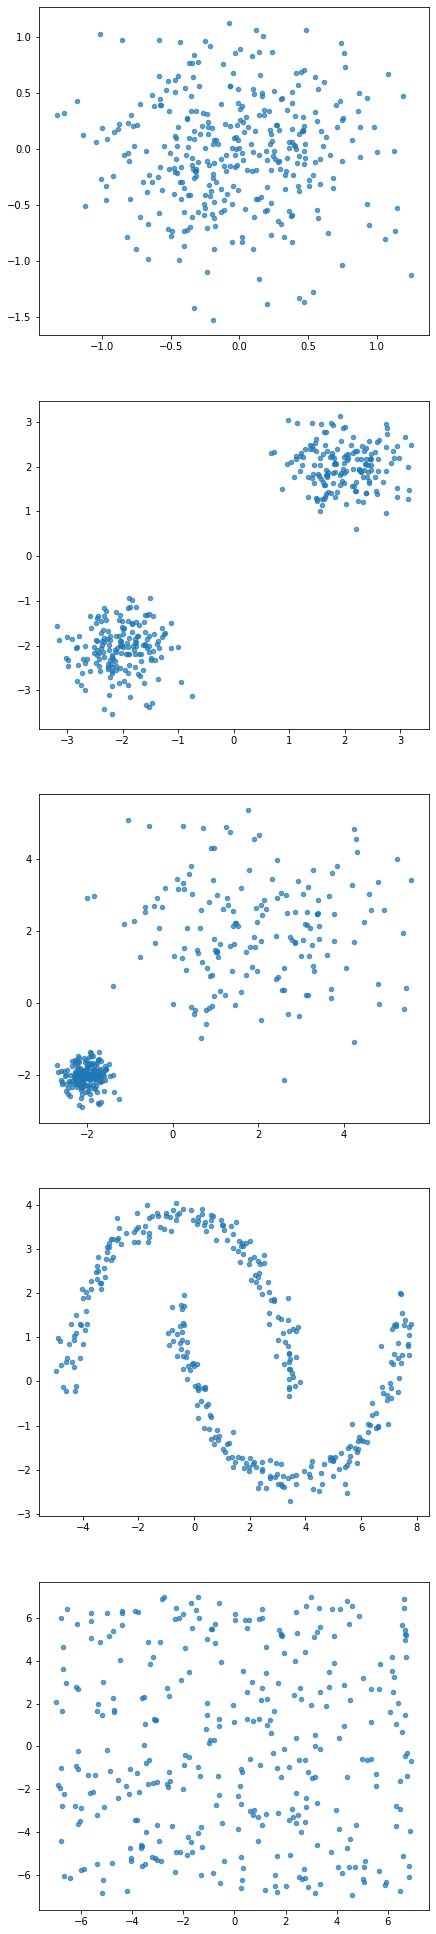

In [40]:
fig, axes = plt.subplots(nrows=len(X_trains), ncols=1, figsize=(7, len(X_trains)*7))
for n, ax in enumerate(axes):
    ax.scatter(X_trains[n][:,0], X_trains[n][:,1], s=20, alpha=0.7)
    
plt.show()

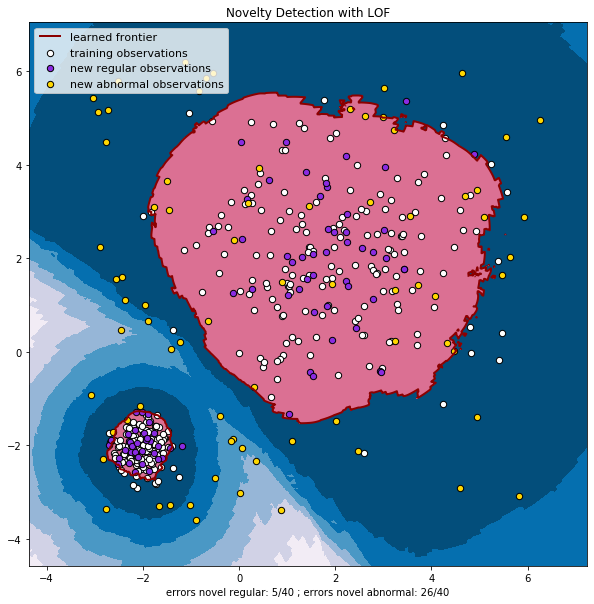

In [49]:

data_num = 2
delta_ratio = 0.2

X_train = X_trains[data_num]
X_test = X_tests[data_num][y_test == 0]
X_outliers = X_tests[data_num][y_test == 1]

max_values = X_train.max(axis=0)
min_values = X_train.min(axis=0)
delta = delta_ratio * (max_values - min_values)

xx, yy = np.meshgrid(np.linspace(min_values[0]-delta[0], max_values[0]+delta[0], 500), 
                     np.linspace(min_values[1]-delta[1], max_values[1]+delta[1], 500))
# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)
# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the learned frontier, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_test, n_error_outliers))
plt.show()

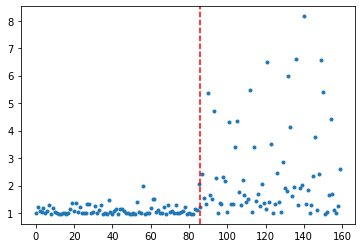

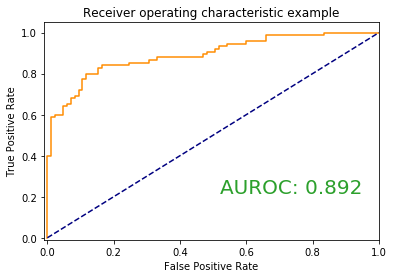

In [54]:
y_pred = np.r_[y_pred_test, y_pred_outliers]
X_test = X_tests[data_num]
anomaly_score = - clf.score_samples(X_test)
n_test_inliers = sum(y_test == 0)

auroc = roc_auc_score(y_test, anomaly_score)

plt.plot(anomaly_score,".")
plt.axvline(x = n_test_inliers + 1, color='r', linestyle='--', label='normal:abnormal')
plt.show()

x, y , _ = roc_curve(y_test, anomaly_score)
plt.plot(x,y, color="darkorange" )
plt.title("Receiver operating characteristic example")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.text(0.95, 0.2, "AUROC: " +str(round(auroc, 3)), {"color": "C2", "fontsize": 20},
va="bottom", ha="right")

plt.xlim([- 0.01, 1.0])
plt.ylim([- 0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


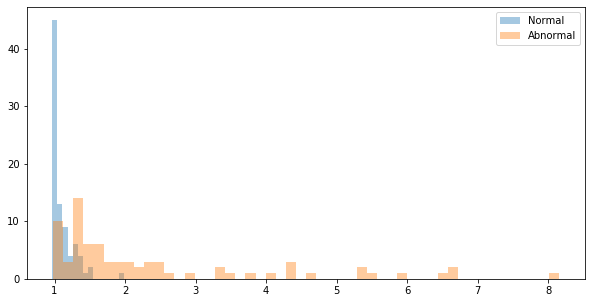

In [55]:
plt.figure(figsize=(10,5))
sns.distplot(anomaly_score[:n_test_inliers],kde=False, label="Normal")
sns.distplot(anomaly_score[n_test_inliers:],bins=50, kde=False, label="Abnormal")
plt.legend()